In [10]:
! pip install pydub
! pip install librosa

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [222]:
from scipy.io import wavfile
from librosa import resample, load
import numpy as np

data_initial, sample_rate_intial = load("Sweep20-20_20sec_-6dB_48k-_1_.wav", sr=None)
data_micro, sample_rate_micro = load("свипер_записанный.wav", sr=None)

print('Длины аудиосигналов: ', len(data_initial), len(data_micro))
print('Частоты дискретизации: ', sample_rate_intial, sample_rate_micro)

Длины аудиосигналов:  958056 882688
Частоты дискретизации:  48000 44100


In [223]:
sr_micro_new = 48000
resampled_micro = resample(data_micro, orig_sr=sample_rate_micro, target_sr=sr_micro_new)

(958056,)
(960749,)


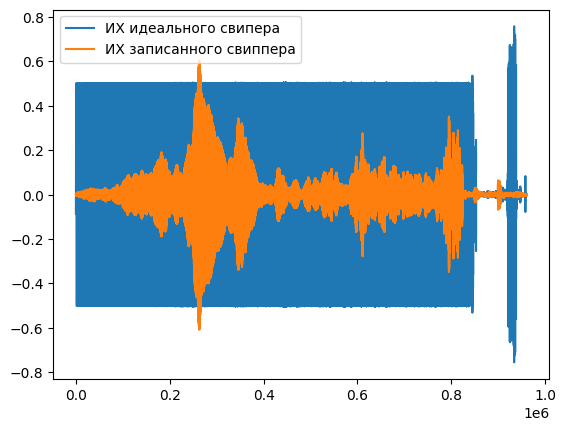

In [315]:
from scipy.fft import fft, fftfreq, ifft
import matplotlib.pyplot as plt

print(data_initial.shape)
print(resampled_micro.shape)

plt.plot(data_initial)
plt.plot(resampled_micro)
plt.legend(['ИХ идеального свипера', 'ИХ записанного свиппера'])

In [316]:
ref_aligned, target_aligned, delay = align_signals(resampled_micro, data_initial)

Сдвиг: 21447 отсчетов


In [317]:
print('Длины аудиосигналов: ', len(ref_aligned), len(target_aligned))

Длины аудиосигналов:  960749 960749


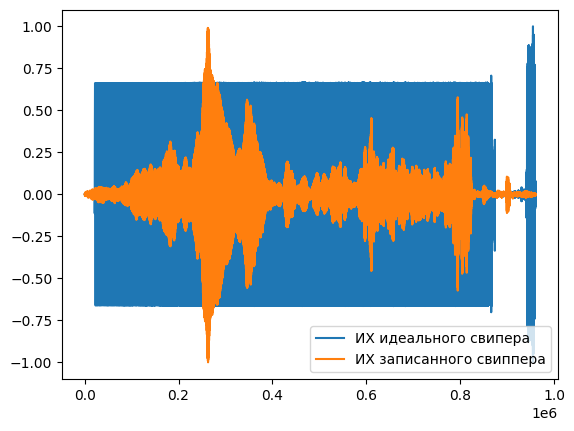

In [318]:
plt.plot(target_aligned)
plt.plot(ref_aligned)
plt.legend(['ИХ идеального свипера', 'ИХ записанного свиппера'])

In [319]:
# выравнивание сигналов по времени
def align_signals(ref, target):
    # Нормализация (по максимуму, чтобы сравнение было корректным)
    ref = ref / np.max(np.abs(ref))
    target = target / np.max(np.abs(target))

    # Кросс-корреляция (mode='full' ищет все возможные сдвиги)
    corr = np.correlate(target, ref, mode='full')
    delay = np.argmax(corr) - len(ref) + 1

    print(f"Сдвиг: {delay} отсчетов")

    # Сдвигаем сигнал target относительно ref
    if delay > 0:
        aligned = np.pad(target, (delay, 0), mode='constant')
    else:
        aligned = target[-delay:]

    # Усечение или дополнение: выравниваем длины (если нужно)
    min_len = min(len(ref), len(aligned))
    ref_aligned = ref[:min_len]
    target_aligned = aligned[:min_len]

    return ref_aligned, target_aligned, delay

Text(0, 0.5, 'амплитуда')

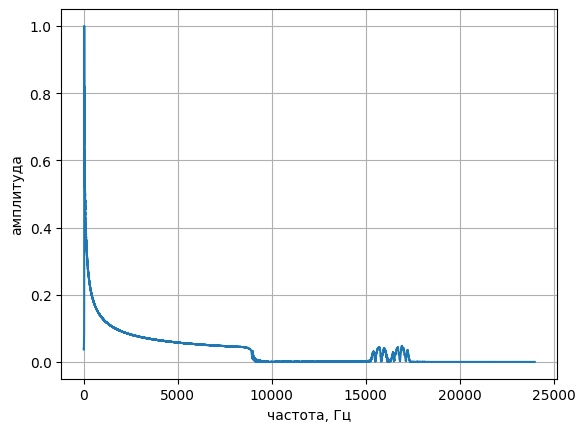

In [320]:
spectrum_initial = np.abs(fft(target_aligned))
specrt_normilized_in = spectrum_initial / np.max(spectrum_initial)
xf1 = fftfreq(len(spectrum_initial), 1 / sample_rate_intial)

positive_freq1 = xf1[:len(target_aligned) // 2]

plt.plot(positive_freq1, specrt_normilized_in[:len(target_aligned) // 2])
plt.grid()
plt.xlabel('частота, Гц')
plt.ylabel('амплитуда')

Text(0, 0.5, 'амплитуда')

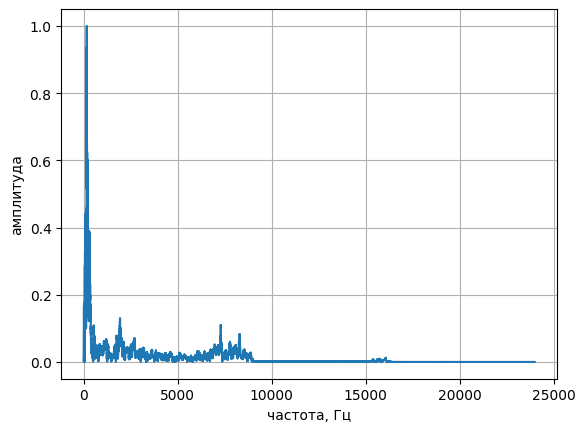

In [321]:
spectrum = np.abs(fft(ref_aligned))
specrt_normilized = spectrum / np.max(spectrum)
xf2 = fftfreq(len(ref_aligned), 1 / sr_micro_new)

positive_freq2 = xf2[:len(ref_aligned) // 2]

plt.plot(positive_freq2, specrt_normilized[:len(ref_aligned) // 2])
plt.grid()
plt.xlabel('частота, Гц')
plt.ylabel('амплитуда')

In [322]:
coeffs_in = get_coeffs(specrt_normilized_in[:len(target_aligned) // 2])
coeffs = get_coeffs(specrt_normilized[:len(ref_aligned) // 2])

In [323]:
print(coeffs_in)
print()
print(coeffs)

[2.50845701e-01 1.23407111e-01 9.46696922e-02 7.98343122e-02
 7.03263804e-02 6.35794923e-02 5.84479272e-02 5.43980412e-02
 5.10989018e-02 4.83448654e-02 4.59610485e-02 4.00287956e-02
 3.59706813e-03 2.31089885e-04 3.02078057e-04 3.26282781e-04
 3.03764333e-04 3.49944399e-04 3.88318382e-04 5.90361597e-04
 1.66261606e-02 1.80867817e-02 2.66810320e-02 2.32644938e-03
 1.56104201e-04 9.35871321e-06 9.14356042e-06 9.02679312e-06
 8.93539618e-06 8.85569989e-06 8.80662992e-06 8.78287938e-06]

[1.51820511e-01 3.15284207e-02 4.16967459e-02 3.24621387e-02
 2.04434562e-02 1.63696110e-02 1.41015770e-02 1.07858488e-02
 1.68741122e-02 3.24740820e-02 2.90693119e-02 2.10918430e-02
 8.76990263e-04 1.22490223e-04 1.23594480e-04 1.26808183e-04
 1.17972777e-04 1.16053452e-04 1.19865770e-04 1.39939017e-04
 2.40406138e-03 2.64955102e-03 3.86504071e-05 9.45074771e-06
 5.70335715e-06 3.71104670e-06 3.30261196e-06 2.87200464e-06
 7.65827679e-07 1.79902287e-07 1.25398003e-07 1.02903634e-07]


In [324]:
gains = coeffs / coeffs_in
inv_gains = 1 / gains
print(inv_gains)

[  1.65225172   3.91415452   2.27043358   2.45930538   3.44004358
   3.8839953    4.1447795    5.04346408   3.02824239   1.48872154
   1.58108484   1.89783299   4.10160555   1.88659862   2.44410638
   2.573042     2.57486804   3.0153726    3.23961029   4.2187062
   6.9158636    6.8263572  690.31697333 246.16564216  27.37058137
   2.52185272   2.76858454   3.14302874  11.66763285  49.22505458
  70.22942714  85.3505268 ]


48000

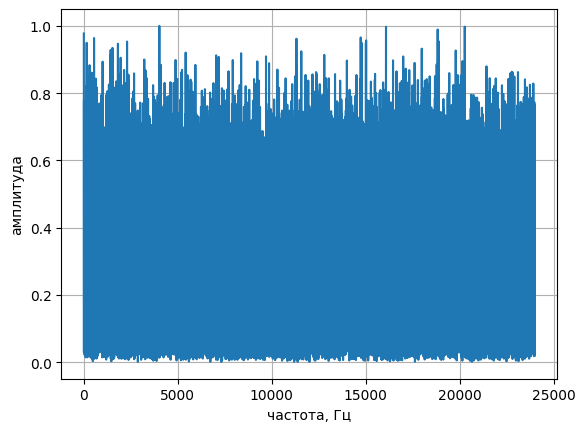

In [354]:
noise, noise_sample_rate = load("370830__deleted_user_5959249__white-noise.wav", sr=None)
spectr_noise = np.abs(fft(noise))

noise_normilized = spectr_noise / np.max(spectr_noise)
xf3 = fftfreq(len(noise), 1 / noise_sample_rate)

positive_freq3 = xf3[:len(noise_normilized) // 2]

plt.plot(positive_freq3, noise_normilized[:len(noise_normilized) // 2])
plt.grid()
plt.xlabel('частота, Гц')
plt.ylabel('амплитуда')
noise_sample_rate

In [352]:
np.real(ifft(noise_normilized))

array([ 2.7872169e-01,  1.6656579e-04, -1.3683033e-05, ...,
        1.6632123e-04, -1.3683033e-05,  1.6656579e-04], dtype=float32)

In [326]:
afr = noise_normilized[:len(noise_normilized) // 2]
elem_in_lane = len(afr) // 32

for k in range(1, 32):
    afr[(k - 1) * elem_in_lane : k * elem_in_lane] *= inv_gains[k]
afr[31 * elem_in_lane : len(afr)] *= inv_gains[31]

afr

array([ 3.826638  ,  0.23576972,  0.2836675 , ..., 34.244583  ,
       10.948283  , 32.174538  ], dtype=float32)

np.float32(688.5053)

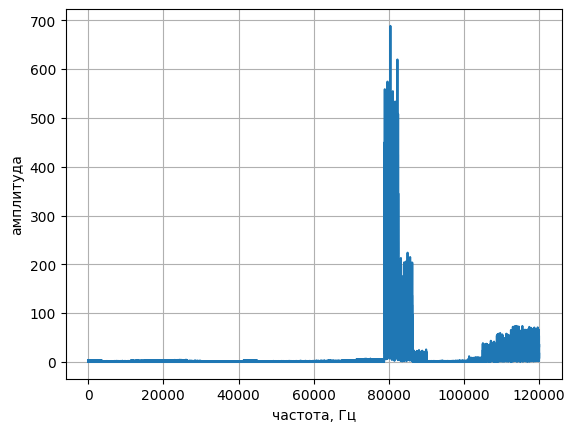

In [327]:
plt.plot(afr)
plt.grid()
plt.xlabel('частота, Гц')
plt.ylabel('амплитуда')
max(afr)

Text(0, 0.5, 'амплитуда')

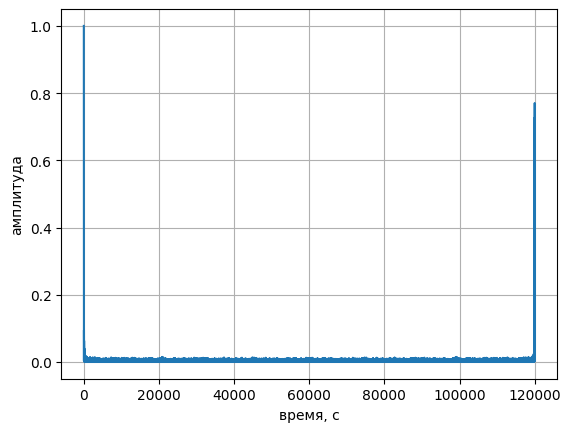

In [353]:
atr = np.abs(ifft(afr))
atr = atr / max(atr)
plt.plot(atr)
plt.grid()
plt.xlabel('время, с')
plt.ylabel('амплитуда')

In [356]:
import soundfile as sf

sf.write("noice_my.wav", atr, noise_sample_rate)

In [289]:
def get_coeffs(ampl_freq_resp, number_of_lanes = 32, flag = 1) -> np.array:
    # flag: 0 - mean, 1 - median
    res = np.zeros(number_of_lanes)
    elem_in_lane = len(ampl_freq_resp) // number_of_lanes
    for k in range(1, number_of_lanes):
        if flag == 0:
            res[k - 1] = np.median(ampl_freq_resp[(k - 1) * elem_in_lane : k * elem_in_lane])
        elif flag == 1:
            res[k - 1] = np.mean(ampl_freq_resp[(k - 1) * elem_in_lane : k * elem_in_lane])
        else:
            raise ValueError("Некорректное значение флага!")
    if flag == 0 : res[number_of_lanes - 1] = np.median(ampl_freq_resp[k * elem_in_lane : len(ampl_freq_resp)])
    elif flag == 1: res[number_of_lanes - 1] = np.mean(ampl_freq_resp[k * elem_in_lane : len(ampl_freq_resp)])
    else : raise ValueError("Некорректное значение флага!")

    return res
